In [1]:
import itertools
import time
import pandas as pd
import numpy as np
import copy
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Import data

In [2]:
data = pd.read_csv('../../data/train_airbnb_berlin_preprocessed.csv', delimiter = ';')

# Prepare data for linear regression

In [3]:
# Now that we have extracted all the gender info from 'Host Name' we delete the feature
del data['Host Name']

# All the information in 'Postal Code' is in 'Longitude', 'Latitude', 'neighborhood' and 'Neighborhood Group'
del data['Postal Code']

# Just for now
del data['neighbourhood']

In [4]:
# We encode 'Neighborhood Group' classes into a one hot encoder
data = pd.get_dummies(data, columns=['Neighborhood Group'], dtype = 'int64')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15268 entries, 0 to 15267
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Host Since                                   15268 non-null  int64  
 1   Host Response Rate                           15268 non-null  float64
 2   Is Superhost                                 15268 non-null  int64  
 3   Latitude                                     15268 non-null  float64
 4   Longitude                                    15268 non-null  float64
 5   Is Exact Location                            15268 non-null  int64  
 6   Accomodates                                  15268 non-null  int64  
 7   Bathrooms                                    15268 non-null  float64
 8   Bedrooms                                     15268 non-null  float64
 9   Beds                                         15268 non-null  float64
 10

In [6]:
data.describe()

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Neighborhood Group_Lichtenberg,Neighborhood Group_Marzahn - Hellersdorf,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick
count,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,...,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.000000,15268.00000,15268.000000
mean,1488.516964,0.921210,0.153393,52.509898,13.407423,0.738538,2.621561,1.086848,1.142127,1.583639,...,0.033076,0.007401,0.202974,0.158305,0.158108,0.013099,0.003537,0.019059,0.06864,0.027050
std,736.837749,0.140309,0.360377,0.031154,0.057981,0.439445,1.380354,0.275211,0.608642,1.039792,...,0.178840,0.085714,0.402226,0.365039,0.364855,0.113704,0.059368,0.136739,0.25285,0.162235
min,0.000000,0.000000,0.000000,52.369270,13.121400,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,979.000000,0.920000,0.000000,52.488920,13.376430,0.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1467.000000,0.920000,0.000000,52.509120,13.417355,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,2051.000000,1.000000,0.000000,52.532702,13.439730,1.000000,3.000000,1.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,3701.000000,1.000000,1.000000,52.639670,13.709020,1.000000,16.000000,3.000000,5.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# Split train and test sets

In [7]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=0)

[]

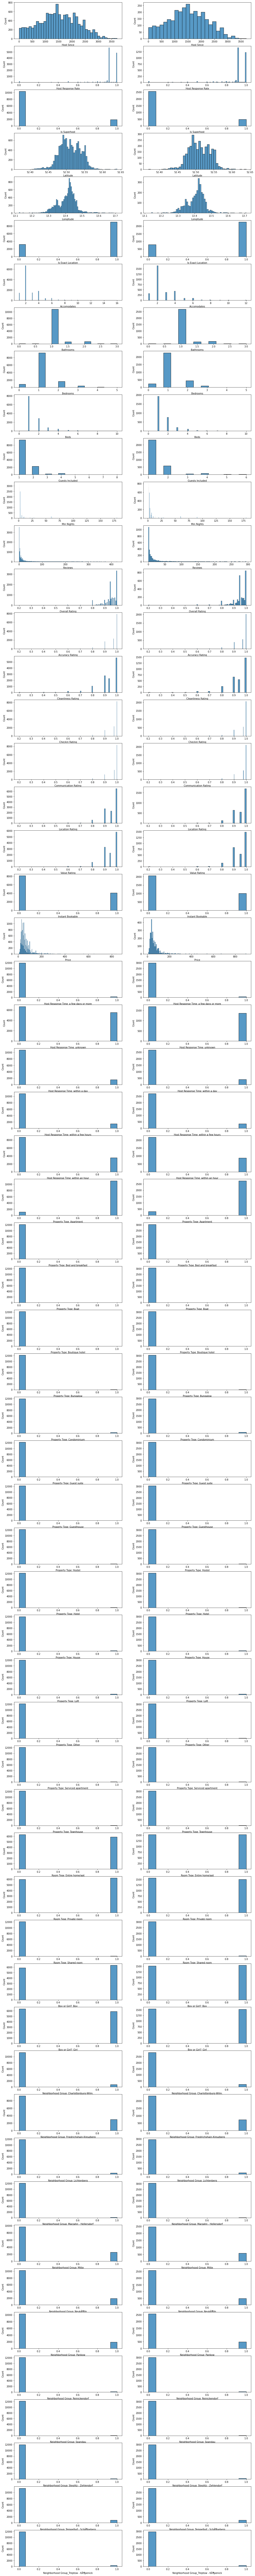

In [8]:
fig = plt.figure(figsize=(18, 200))
gs = GridSpec(len(data.columns), 2)

for index, feature in enumerate(data.columns):
    ax = fig.add_subplot(gs[index, 0])
    sb.histplot(train_set, x=feature, ax=ax)
    ax = fig.add_subplot(gs[index, 1])
    sb.histplot(test_set, x=feature, ax=ax)

plt.plot()

# All variables seem very alicke in both train and test sets so there is no need to stratify

In [9]:
# If you want to you can check for specific variable proportions with this code

def feature_proportions(data, feature):
    return data[feature].value_counts() / len(data)


compare_props = pd.DataFrame({
    "Input_dataset": feature_proportions(data, 'Boy or Girl?_Boy'),
    "Train_set": feature_proportions(train_set, 'Boy or Girl?_Boy'),
    "Test_set": feature_proportions(test_set, 'Boy or Girl?_Boy')
}).sort_index()
compare_props["Test set. %error"] = 100 * compare_props["Test_set"] / compare_props["Input_dataset"] - 100
compare_props["Train set. %error"] = 100 * compare_props["Train_set"] / compare_props["Input_dataset"] - 100

compare_props

,Input_dataset,Train_set,Test_set,Test set. %error,Train set. %error
0,0.483102,0.480023,0.495416,2.548931,-0.637337
1,0.516898,0.519977,0.504584,-2.382275,0.595666


In [10]:
def create_matrices(train_set, test_set):
        
    X_train = train_set.drop('Price', axis=1)
    y_train = train_set["Price"].copy()

    X_test = test_set.drop("Price", axis=1)
    y_test = test_set["Price"].copy()
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = create_matrices(train_set, test_set)

# Standardize data

In [11]:
features = X_train.columns
initial_categorical_features = [
    'Is Superhost', 
    'Is Exact Location', 
    'Instant Bookable',
    'Host Response Time',
    'Property Type',
    'Room Type',
    'Boy or Girl',
    'Neighborhood Group'
]
numerical_features = []
categorical_features = []

for feature in features:
    for initial_categorical_feature in initial_categorical_features:
        if initial_categorical_feature in feature:
            categorical_features.append(feature)
    if feature not in categorical_features:
        numerical_features.append(feature)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Linear Regression

### Looking for best subset
There are wy to much features to implement a brute force methode so we will use forward and backward stepwise selection

In [13]:
def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    results = []
    
    for d in remaining_features:
        model = LinearRegression()
        regr = model.fit(X_train[features+[d]], y_train)
        RSS = ((regr.predict(X_test[features+[d]]) - y_test) ** 2).sum()
        results.append({"model":regr, "features":features+[d], "RSS":RSS})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model


def backward(features):
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        combo = list(combo)
        model = LinearRegression()
        regr = model.fit(X_train[combo], y_train)
        RSS = ((regr.predict(X_test[combo]) - y_test) ** 2).sum()
        results.append({"model":regr, "features":combo, "RSS":RSS})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [14]:
# Build  best models acording to forward stepwise selection

models_fwd = pd.DataFrame(columns=["RSS", "features", "model"])

tic = time.time()
features = []

for i in range(1,len(X_train.columns)+1):  
    model = forward(features)
    models_fwd.loc[i] = model
    features = model["features"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 16.452098846435547 seconds.


In [15]:
# Build  best models acording to backward stepwise selection

models_bwd = pd.DataFrame(columns=["RSS", "features", "model"], index = range(1,len(X_train.columns)))

tic = time.time()
features = X_train.columns

while(len(features) > 1): 
    model = backward(features)
    models_bwd.loc[len(features)-1] = model
    features = model["features"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 28.252076148986816 seconds.


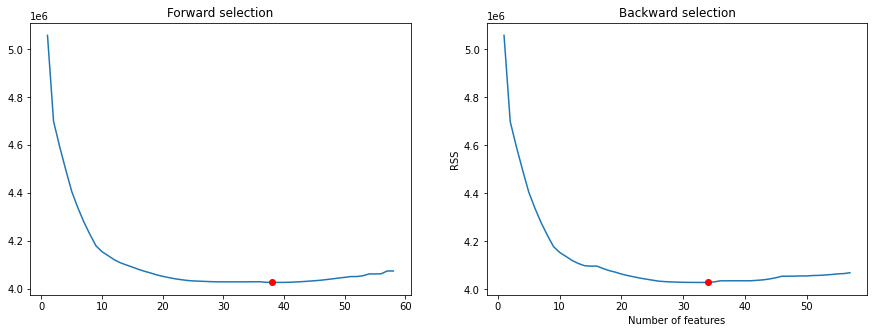

Minimum RSS achieved for forward selection: 38
Minimum RSS achieved for backward selection: 34


In [16]:
# Plot RSS of all selected models in order to chose the best feature subset possible

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

models_fwd = models_fwd.astype({'RSS': 'float64'})
ax1.plot(models_fwd["RSS"])
plt.xlabel('Number of features')
plt.ylabel('RSS')
ax1.set_title('Forward selection')
ax1.plot(models_fwd["RSS"].argmin()+1, models_fwd["RSS"].min(), "or")

models_bwd = models_bwd.astype({'RSS': 'float64'})
ax2.plot(models_bwd["RSS"])
plt.xlabel('Number of features')
plt.ylabel('RSS')
ax2.set_title('Backward selection')
ax2.plot(models_bwd["RSS"].argmin()+1, models_bwd["RSS"].min(), "or")

plt.show()

print('Minimum RSS achieved for forward selection: ' + str(models_fwd["RSS"].argmin()+1))
print('Minimum RSS achieved for backward selection: ' + str(models_bwd["RSS"].argmin()+1))

### Training 
To get the full model, we would train on the full data.

In [17]:
X = data.drop('Price', axis=1)
y = data["Price"].copy()
        
std_scaler = StandardScaler()
std_scaler.fit(X[numerical_features])
X[numerical_features] = std_scaler.transform(X[numerical_features])

In [18]:
# Build best 39 feature model acording to forward stepwise selection

def forward_full_dataset(features):

    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]
    
    results = []
    
    for d in remaining_features:
        model = LinearRegression()
        regr = model.fit(X[features+[d]], y)
        RSS = ((regr.predict(X[features+[d]]) - y) ** 2).sum()
        results.append({"model":regr, "features":features+[d], "RSS":RSS})
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_final = pd.DataFrame(columns=["RSS", "features", "model"])

tic = time.time()
features = []

for i in range(1,len(X.columns)+1):  
    model = forward_full_dataset(features)
    models_final.loc[i] = model
    features = model["features"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Total elapsed time: 28.89658784866333 seconds.


In [19]:
print(models_final.loc[39, "features"])

['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Bedrooms', 'Property Type_Loft', 'Property Type_Hotel', 'Guests Included', 'Property Type_Serviced apartment', 'Location Rating', 'Host Response Time_unknown', 'Neighborhood Group_Mitte', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Neighborhood Group_Charlottenburg-Wilm.', 'Neighborhood Group_Pankow', 'Latitude', 'Min Nights', 'Cleanliness Rating', 'Value Rating', 'Property Type_Condominium', 'Property Type_Boutique hotel', 'Neighborhood Group_Treptow - KÃ¶penick', 'Property Type_Boat', 'Overall Rating', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Marzahn - Hellersdorf', 'Room Type_Private room', 'Is Superhost', 'Reviews', 'Longitude', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_Hostel', 'Is Exact Location', 'Property Type_Bed and breakfast', 'Property Type_House', 'Host Since', 'Host Response Time_a few days or more', 'Property Type_Other', 'Host Resp

### Testing
For the testing we will use the model trained only on the training set in order to be able to compare it to the other models we are trying out in other notebooks.

In [20]:
model = models_fwd.loc[39, "model"]
features = models_fwd.loc[39, "features"]
RSS = models_fwd.loc[39, "RSS"]
y_pred = model.predict(X_test[features])

print('Model features: '+str(features))
print(' ')
print('Model RSS on test set: '+str(RSS))

Model features: ['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Property Type_Hotel', 'Guests Included', 'Property Type_Loft', 'Property Type_Serviced apartment', 'Bedrooms', 'Location Rating', 'Host Response Time_unknown', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_NeukÃ¶lln', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Property Type_Boat', 'Is Superhost', 'Value Rating', 'Min Nights', 'Cleanliness Rating', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_Hostel', 'Neighborhood Group_Spandau', 'Room Type_Shared room', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Instant Bookable', 'Host Response Time_within an hour', 'Property Type_Other', 'Property Type_Guesthouse', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_House', 'Property Type_Townhouse', 'Host Response Time_within a few hours', 'Longitude', 'Lat

In [21]:
MSE = mean_squared_error(y_pred, y_test) 
print('Model MSE on test set: '+str(MSE))

Model MSE on test set: 1318.3567960179832


<AxesSubplot:ylabel='Count'>

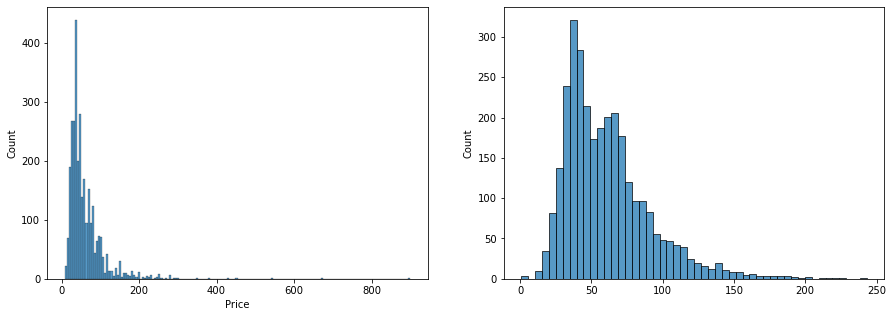

In [22]:
# Prediction distribution against real distribution

fig = plt.figure(figsize=(15,5)) 
(ax1, ax2) = fig.subplots(1, 2)

sb.histplot(y_test, ax=ax1)
sb.histplot(y_pred, ax=ax2)

We observe that altough the distributions are alike, high prices cannot be predicted correctly. A lot of the error is probably explained by theses extreme points.

In [23]:
# Importance of each feature in the predictions

correlations = {}

for feature in features:
    correlations[pearsonr(X_test[feature], y_pred)[0]] = feature
sorted_correlations = sorted(correlations.keys(), reverse=True)

print('Correlations in order :')
print(' ')
for r in sorted_correlations:
    print('Between the prediction and '+ correlations[r] + ' : r=' + str(r))

Correlations in order :
 
Between the prediction and Accomodates : r=0.8100214978323698
Between the prediction and Bedrooms : r=0.6675197854629003
Between the prediction and Room Type_Entire home/apt : r=0.6579384542096616
Between the prediction and Guests Included : r=0.5783121162778946
Between the prediction and Bathrooms : r=0.4148932229240749
Between the prediction and Property Type_Loft : r=0.28394677041119465
Between the prediction and Host Response Time_within an hour : r=0.1440629700084085
Between the prediction and Property Type_Serviced apartment : r=0.11712851607951436
Between the prediction and Property Type_Hotel : r=0.11706804435186624
Between the prediction and Cleanliness Rating : r=0.10269954119433494
Between the prediction and Location Rating : r=0.0932678931840452
Between the prediction and Latitude : r=0.08888544976720134
Between the prediction and Is Superhost : r=0.07785607743924279
Between the prediction and Host Response Time_within a few hours : r=0.06263687094

# Alternative : build linear regression after dimentionality reduction through a PCA

### PCA

In [24]:
pca = PCA()
X_reduced = pca.fit_transform(scale(data.drop('Price', axis=1)))
y = data['Price']

X_reduced_train, X_reduced_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=0
)

We use 10-fold cross validation to see how the principal components influence the MSE.

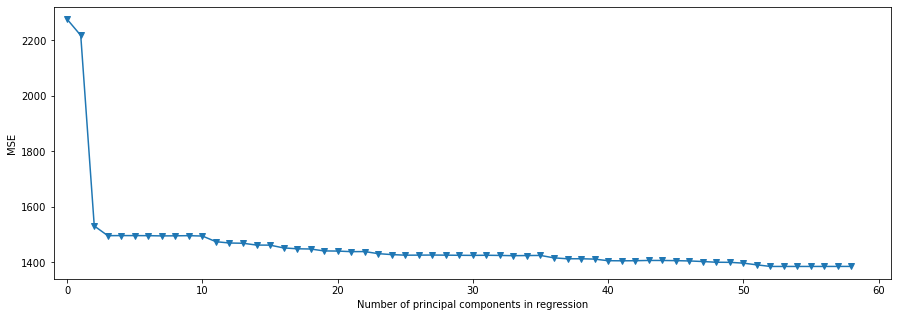

In [25]:
# 10-fold CV, with shuffle
n = len(X_reduced_train)

kf_10 = KFold( n_splits=10, shuffle=True, random_state=0)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 58 principal components, adding one component at the time.
for i in np.arange(1, len(X_reduced_train[0])+1):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.figure(figsize=(15,5))
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1);

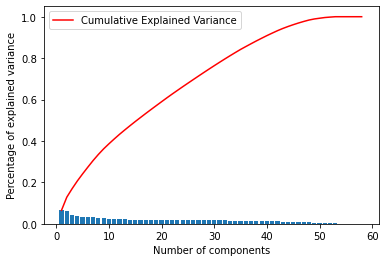

In [26]:
# Part of explained variance per component

plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

### Model with 3 components.

In [27]:
pca_3 = PCA(n_components = 3)
pca_3.fit(scale(data.drop('Price', axis=1)))

model_3 = LinearRegression()
model_3 = model_3.fit(X_reduced_train[:,:3], y_train)

y_pred_3 = model_3.predict(X_reduced_test[:,:3])

Text(0.5, 1.0, 'The effect of features on each components')

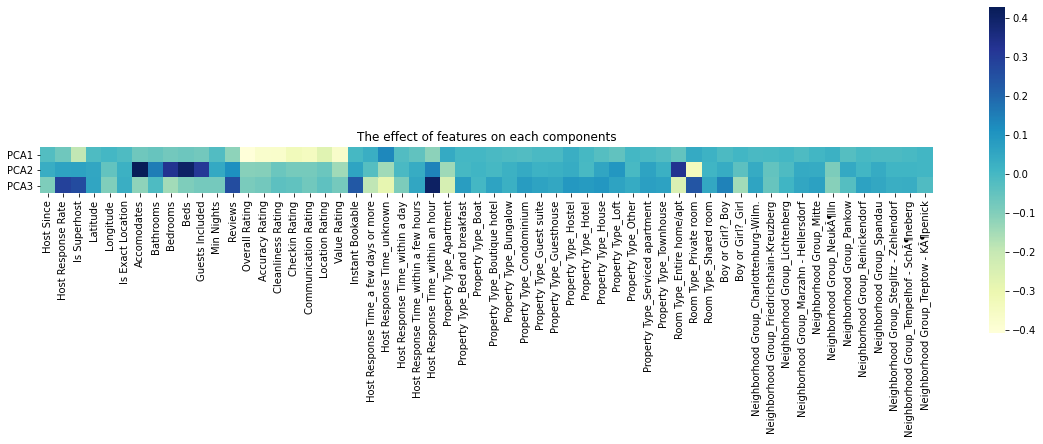

In [28]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,6))
ax = sns.heatmap(pca_3.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_3.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Model with 11 components

In [29]:
pca_11 = PCA(n_components = 11)
pca_11.fit(scale(data.drop('Price', axis=1)))

model_11 = LinearRegression()
model_11 = model_11.fit(X_reduced_train[:,:11], y_train)

y_pred_11 = model_11.predict(X_reduced_test[:,:11])

Text(0.5, 1.0, 'The effect of features on each components')

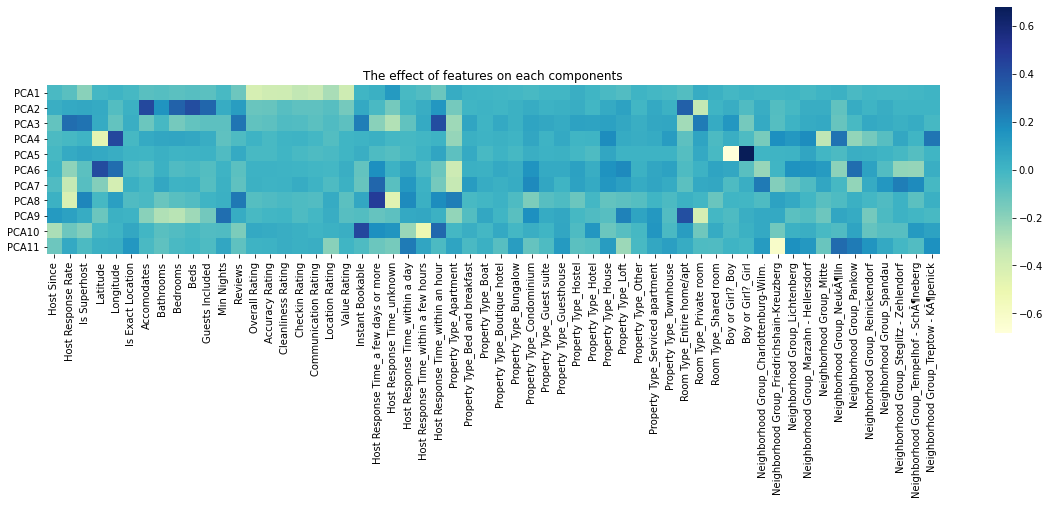

In [30]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,6))
ax = sns.heatmap(pca_11.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_11.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Model with 36 components

In [31]:
pca_36 = PCA(n_components = 36)
pca_36.fit(scale(data.drop('Price', axis=1)))

model_36 = LinearRegression()
model_36 = model_36.fit(X_reduced_train[:,:36], y_train)

y_pred_36 = model_36.predict(X_reduced_test[:,:36])

Text(0.5, 1.0, 'The effect of features on each components')

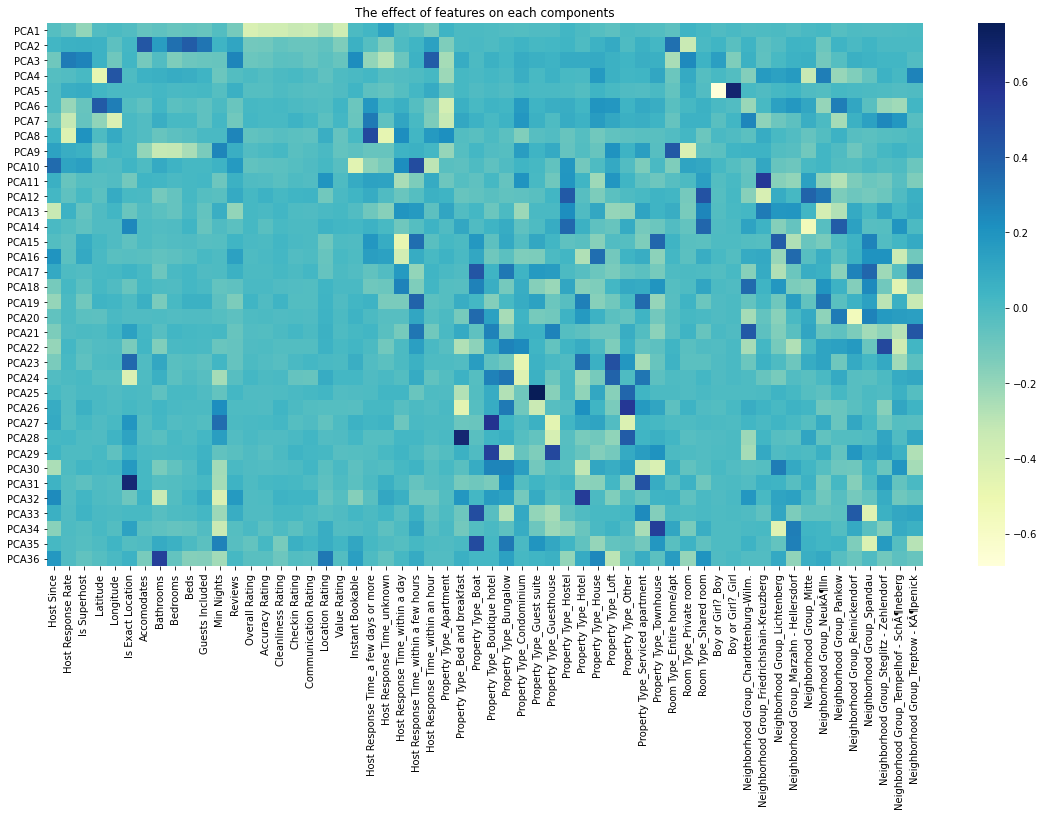

In [32]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,10))
ax = sns.heatmap(pca_36.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_36.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Model with 51 components

In [33]:
pca_51 = PCA(n_components = 51)
pca_51.fit(scale(data.drop('Price', axis=1)))

model_51 = LinearRegression()
model_51 = model_51.fit(X_reduced_train[:,:51], y_train)

y_pred_51 = model_51.predict(X_reduced_test[:,:51])

Text(0.5, 1.0, 'The effect of features on each components')

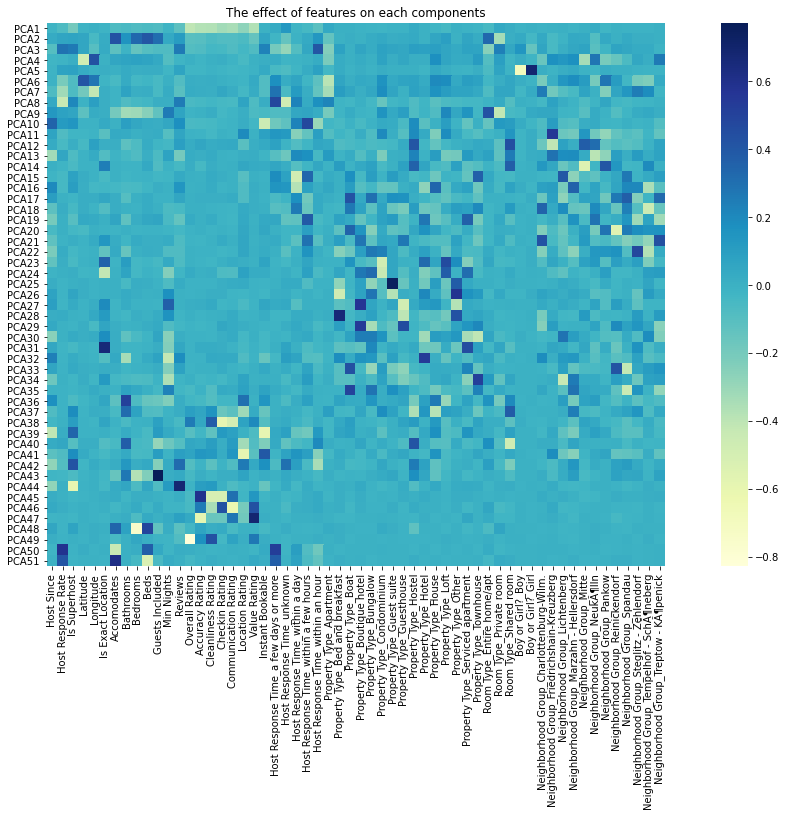

In [34]:
# How do the components influence the initial variables ?

plt.figure(figsize=(20,10))
ax = sns.heatmap(pca_51.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(X_test) for X_test in range(1,pca_51.n_components_+1)],
                 xticklabels=list(X_test.columns),
                 cbar_kws={"orientation": "vertical"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")
plt.title('The effect of features on each components')

### Testing

In [35]:
print('The final test MSEs are: ')
print('3 components model: ',mean_squared_error(y_test, y_pred_3))
print('11 components model: ',mean_squared_error(y_test, y_pred_11))
print('36 components model: ',mean_squared_error(y_test, y_pred_36))
print('51 components model: ',mean_squared_error(y_test, y_pred_51))

The final test MSEs are: 
3 components model:  1444.6144818774355
11 components model:  1438.5503258234294
36 components model:  1340.8064399885227
51 components model:  1339.1382311614882
